## Notebook 3 - EDA on Non-Text Data and Next Steps
The purpose of this notebook is to perform EDA on the non-text aspects of the tweets and create a list of next steps based on findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_pickle('../data/2-all_tweets.p')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92771 entries, 0 to 92770
Data columns (total 17 columns):
author_id                92771 non-null int64
local_datetime           92771 non-null object
favorites                92771 non-null int64
hashtags                 92771 non-null object
id                       92771 non-null object
mentions                 92771 non-null object
permalink                92771 non-null object
retweets                 92771 non-null int64
text                     92771 non-null object
urls                     92771 non-null object
username                 92771 non-null object
country                  92771 non-null object
year                     92771 non-null int64
month                    92771 non-null int64
weekday                  92771 non-null int64
hour                     92771 non-null int64
hashtags_and_mentions    92771 non-null object
dtypes: int64(7), object(10)
memory usage: 12.0+ MB


In [4]:
df.sample(5)

,author_id,local_datetime,favorites,hashtags,id,mentions,permalink,retweets,text,urls,username,country,year,month,weekday,hour,hashtags_and_mentions
67002,239171363,2016-05-31 09:45:35-06:00,3,#fmspca #ymmfire #ymmpets #ymm,737671375922565121,,https://twitter.com/FMSPCA/status/737671375922...,3,To deliver donations to #fmspca Leduc warehous...,,FMSPCA,canada,2016,5,1,9,#fmspca #ymmfire #ymmpets #ymm
36957,33549978,2014-10-31 12:01:33-04:00,0,#funfactfriday #funfact #animalfacts,528215205554429952,,https://twitter.com/OntarioSPCA/status/5282152...,3,#FunFactFriday : A squid’s eye can get as big ...,,OntarioSPCA,canada,2014,10,4,12,#funfactfriday #funfact #animalfacts
77807,69678362,2014-02-17 15:24:32-08:00,0,,435555394618810368,@designlabmedia,https://twitter.com/BC_SPCA/status/43555539461...,0,@designlabmedia On behalf of the all the anima...,http://bit.ly/1g0tcl8,BC_SPCA,canada,2014,2,0,15,@designlabmedia
42186,33549978,2016-09-09 16:01:16-04:00,4,#mushrooms #pet #pettips,774336891273506816,,https://twitter.com/OntarioSPCA/status/7743368...,10,Learn about all the different kinds of toxic #...,http://ontariospca.ca/blog/mushroom-safety-tip...,OntarioSPCA,canada,2016,9,4,16,#mushrooms #pet #pettips
42820,33549978,2016-12-27 08:30:43-05:00,1,,813738884509077504,,https://twitter.com/OntarioSPCA/status/8137388...,3,"Please be advised, our Animal Centres will be ...",,OntarioSPCA,canada,2016,12,1,8,


**Note:**  
Checking to see if only the SPCA's are in the username field. Looks like there are others in there. I'm going to remove them.

In [5]:
df.username.value_counts()

FMSPCA             26899
OntarioSPCA        22635
BC_SPCA            20754
spcaoftexas         5340
sfspca              4205
RichmondSPCA        3766
PSPCA               3466
HoustonSPCA         3064
Tulsa_SPCA          2630
FMUnitedWay            2
Mix1037radio           2
OSPCARenfrew           1
steve_reeve            1
911TheBridge           1
southernpride50        1
kevthegrad             1
DonaldKScott           1
Toddske                1
NorthStarFord          1
Name: username, dtype: int64

In [6]:
# get rid of rows with non-SPCA usernames
df = df.loc[df.username.str.contains('SPCA|spca')]

# also need to drop the one row with username OSPCARenfrew
df = df.loc[df.username != 'OSPCARenfrew']
df.shape

(92759, 17)

**Note:**  
Because of the boost in retweet numbers created by Hurricane Harvey, I researched other natural disasters in the locations of the organizations and I found a few. I'm going to remove all tweets from a few days before and two weeks following any natural disaster. Here's a list of each disaster:
1. Hurricane Harvey (Houston) - made landfall on 8/25/17
2. Alberta Wildfire (Fort McMurray) - started 5/1/16 and under control 6/3/16
3. Moore Tornado (Oklahoma) - touched down 5/20/13

In [7]:
from datetime import datetime
from datetime import timedelta
import pytz

In [8]:
# create disaster dictionary that lists beginning of timeframe as 3 days prior
disaster_dict = {
    'hurricane': datetime(2017,8,22, tzinfo=pytz.timezone('US/Central')),
    'wildfire': datetime(2016,4,29, tzinfo=pytz.timezone('US/Mountain')),
    'tornado': datetime(2013,5,18, tzinfo=pytz.timezone('US/Central'))
}

# remove tweets that are within two weeks of disaster timeframe
for disaster, start in disaster_dict.items():
    end = start + timedelta(days=14)
    df = df.loc[~((df.local_datetime > start) & (df.local_datetime < end))]
    print('Shape after removing {}: {}'.format(disaster,df.shape))

Shape after removing hurricane: (92275, 17)
Shape after removing wildfire: (91861, 17)
Shape after removing tornado: (91148, 17)


**Note:**  
Looking at tweets per user per year in consideration of dropping the first couple years of data.

In [9]:
by_year_user = df.groupby(by=['year','username'],as_index=False,sort=False)[['author_id']].count()
by_year_user.rename(columns = {'author_id': 'num_tweets'}, inplace=True)

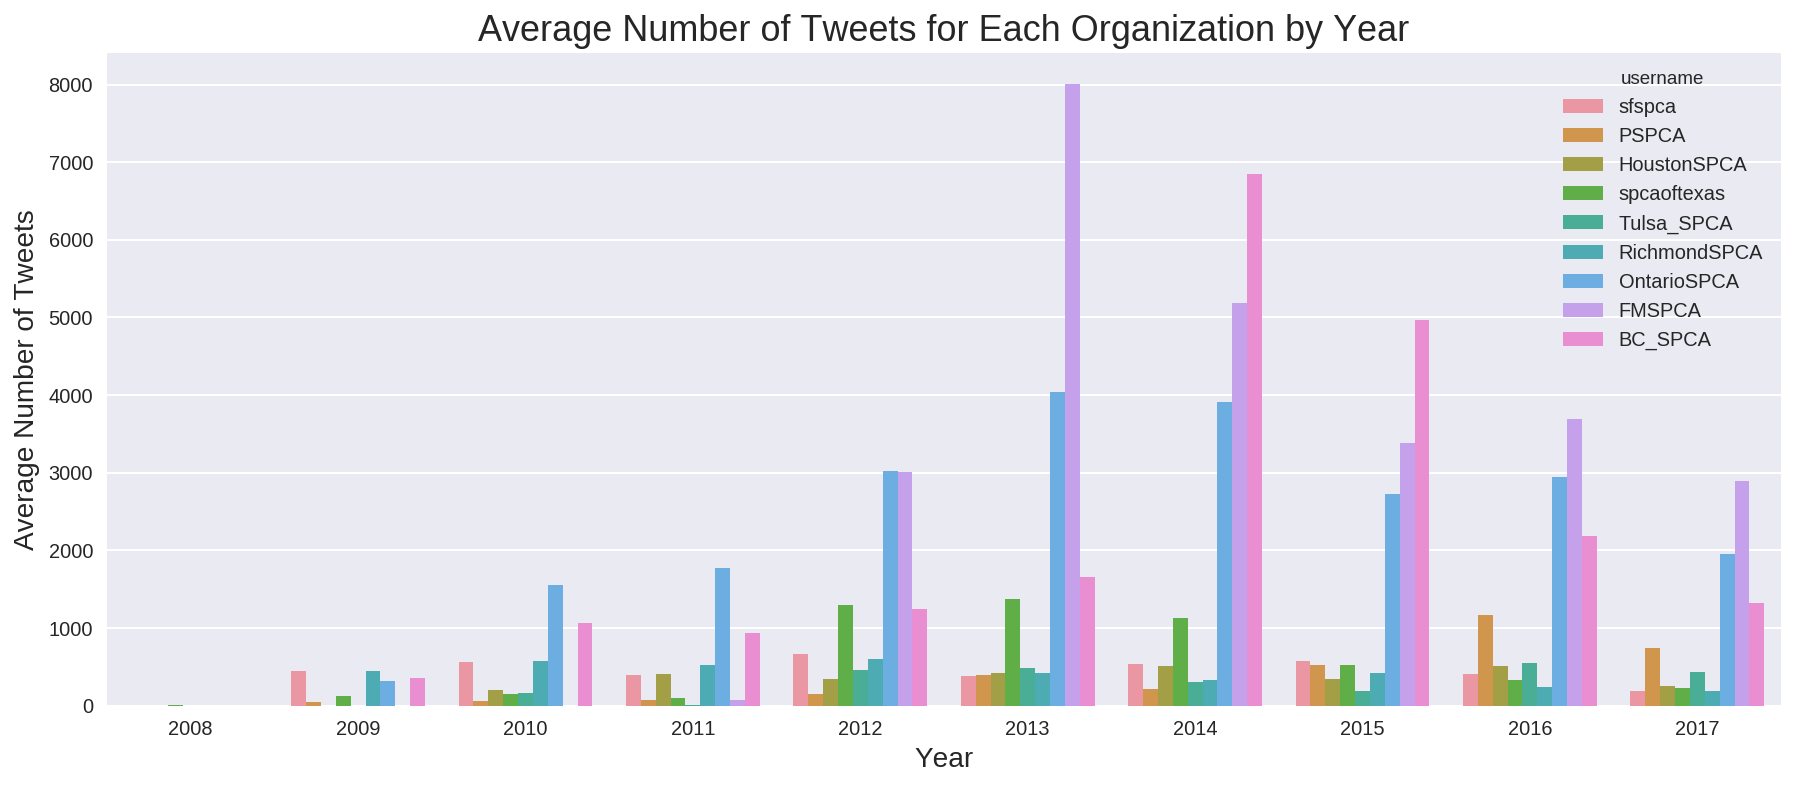

In [10]:
fig = plt.figure(figsize=(15,6))
sns.barplot(x='year', y='num_tweets', hue='username', data=by_year_user, ci=None)
plt.title('Average Number of Tweets for Each Organization by Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Number of Tweets', fontsize=14)
plt.show()

**Note:**  
Dropping all tweets before 2012 since that's when Twitter had IPO and started gaining in popularity.

In [11]:
df = df.loc[df.year > 2011]
df.shape

(80836, 17)

**Note:**  
Because retweets of a tweet create more potential viewers of the tweet than favoriting a tweet does, I'm going to use number of retweets as the scoring metric (and the target for the model). **Future consideration:** In addition to retweets, factor favorites and replies into scoring metric as those represent confirmed views, and also follow the trail of the retweets to get total confirmed views.  
  
For this model, I will not be using favorites as a predictor because it is the result of a tweet and isn't a known value before the tweet is sent.  
  
I will now look at minimizing the effects of outliers by first addressing the skew in the target and then identifying outliers using the Tukey method.

In [12]:
# looking at stats for the target
df[['retweets']].describe()

,retweets
count,80836.000000
mean,4.722401
std,7.672284
min,0.000000
25%,0.000000
50%,2.000000
75%,6.000000
max,407.000000


**Note:**  
With a lot of the data gathered around 0 and very high maximum relative to the mean, median and standard deviation, this data appears heavily skewed right. Need to transform the data to minimize the skew.

In [13]:
# get measure of skew to confirm suspicion stated above
from scipy.stats import skew

retweet_skew = df[['retweets']].apply(lambda x: skew(x))
retweet_skew

retweets    9.106075
dtype: float64

**Note:**  
This is a very high skew measurement (as suspected from the max compared to the mean and median), so I'm going to  transform with `log1p` (add 1 and take the natural log).

In [14]:
df['retweets'] = np.log1p(df['retweets'])

In [15]:
# get measure of skew again for sake of comparison
retweet_skew = df[['retweets']].apply(lambda x: skew(x))
retweet_skew

retweets    0.341354
dtype: float64

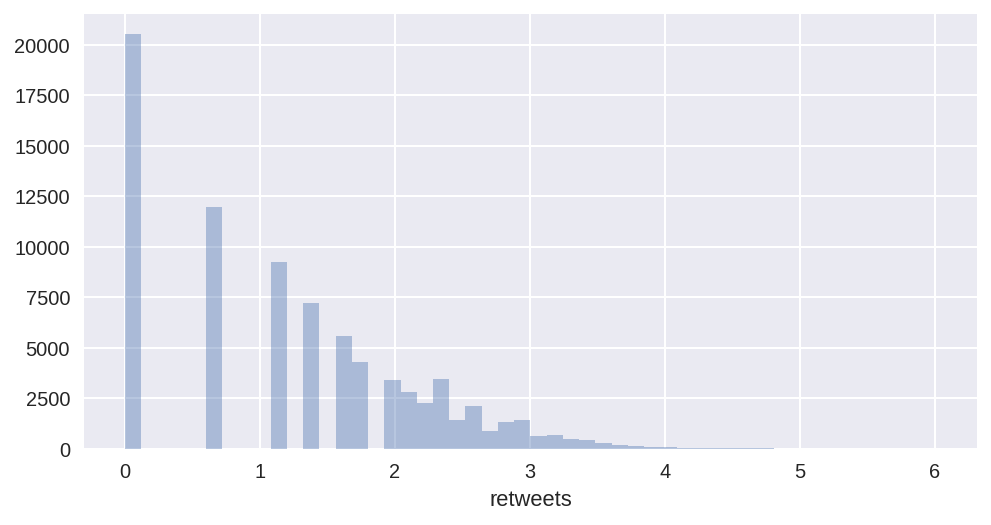

In [16]:
# plot the distribution of retweets
fig = plt.figure(figsize=(8,4))
sns.distplot(df.retweets, kde=False)
plt.show()

**Note:**  
The transformation has significantly reduced the skew. Time to identify outliers.

In [17]:
# function to implement the Tukey method for identifying outliers
def identify_outliers(dataframe, col):
    Q1 = np.percentile(dataframe[col], 25)
    Q3 = np.percentile(dataframe[col], 75)
    tukey_window = 1.5*(Q3-Q1)
    less_than_Q1 = dataframe[col] < Q1 - tukey_window
    greater_than_Q3 = dataframe[col] > Q3 + tukey_window
    tukey_mask = (less_than_Q1 | greater_than_Q3)
    return dataframe[tukey_mask]

In [18]:
outliers = identify_outliers(df,'retweets')
outliers.shape

(14, 17)

In [19]:
outliers

,author_id,local_datetime,favorites,hashtags,id,mentions,permalink,retweets,text,urls,username,country,year,month,weekday,hour,hashtags_and_mentions
3096,22213454,2015-03-19 11:49:33-07:00,197,#koreadogs,578629397164482560,,https://twitter.com/sfspca/status/578629397164...,5.153292,We've helped rescue 57 dogs from a dog meat fa...,http://www.sfspca.org/koreadogs,sfspca,usa,2015,3,3,11,#koreadogs
3466,22213454,2015-10-07 12:10:39-07:00,184,#vetoextinction,651837056172228608,@potus,https://twitter.com/sfspca/status/651837056172...,5.241747,Some Senators don't believe saving endangered ...,,sfspca,usa,2015,10,2,12,#vetoextinction @potus
3851,22213454,2016-08-17 11:31:49-07:00,462,#blackcatappreciationday,765979460734562304,,https://twitter.com/sfspca/status/765979460734...,5.823046,Black cats often have a harder time getting ad...,,sfspca,usa,2016,8,2,11,#blackcatappreciationday
10714,70686845,2017-09-09 13:22:51-05:00,95,,906583695867260929,,https://twitter.com/HoustonSPCA/status/9065836...,5.141664,"If you have space to foster a displaced pet, o...",http://www.FosterAHurricanePet.org,HoustonSPCA,usa,2017,9,5,13,
10716,70686845,2017-09-08 17:05:07-05:00,137,,906277246138281989,,https://twitter.com/HoustonSPCA/status/9062772...,5.361292,Lost a pet? Visit http://www. houstonspca.org/...,"http://www.houstonspca.org/harvey/,http://www....",HoustonSPCA,usa,2017,9,4,17,
15756,16630213,2016-10-18 18:02:47-05:00,440,,788515698473480192,@ezekielelliott,https://twitter.com/spcaoftexas/status/7885156...,5.525453,@EzekielElliott incredibly kind heart and gene...,,spcaoftexas,usa,2016,10,1,18,@ezekielelliott
15763,16630213,2016-10-16 16:14:33-05:00,543,#runtotheshelter,787763688237260800,@ezekielelliott @our,https://twitter.com/spcaoftexas/status/7877636...,5.533389,It's almost time to #RunToTheShelter ! All day...,,spcaoftexas,usa,2016,10,6,16,#runtotheshelter @ezekielelliott @our
15797,16630213,2016-11-14 20:26:49-06:00,841,,798351519829659649,,https://twitter.com/spcaoftexas/status/7983515...,5.488938,We were honored to welcome President George W....,,spcaoftexas,usa,2016,11,0,20,
27450,33549978,2012-06-30 09:28:10-04:00,1,#heatcankill #ospcarescue,219059756030115840,,https://twitter.com/OntarioSPCA/status/2190597...,4.955827,"If you can tweet one thing today, make it a re...",,OntarioSPCA,canada,2012,6,5,9,#heatcankill #ospcarescue
34844,33549978,2014-05-20 11:23:17-04:00,107,#nohotpets,468773964861296640,,https://twitter.com/OntarioSPCA/status/4687739...,5.488938,Hot cars can kill. Visit http:// nohotpets.ca/...,http://nohotpets.ca/?utm_source=RTB&utm_medium...,OntarioSPCA,canada,2014,5,1,11,#nohotpets


**Note:**  
I'm going to keep these outliers as the tweets do not look to be the result of anything extraordinary. They include celebrity visitors, campaigns for pet safety, etc.

### Adding Features  
I'm going to create three more columns that are boolean values, one each for whether or not a tweet has a hashtag, a mention or a url.

In [20]:
# new columns based on presence of mention, hashtag, url
has_one = lambda x: 0 if x == '' else 1
df['has_mention'] = df.mentions.apply(has_one)
df['has_hashtag'] = df.hashtags.apply(has_one)
df['has_url'] = df.urls.apply(has_one)

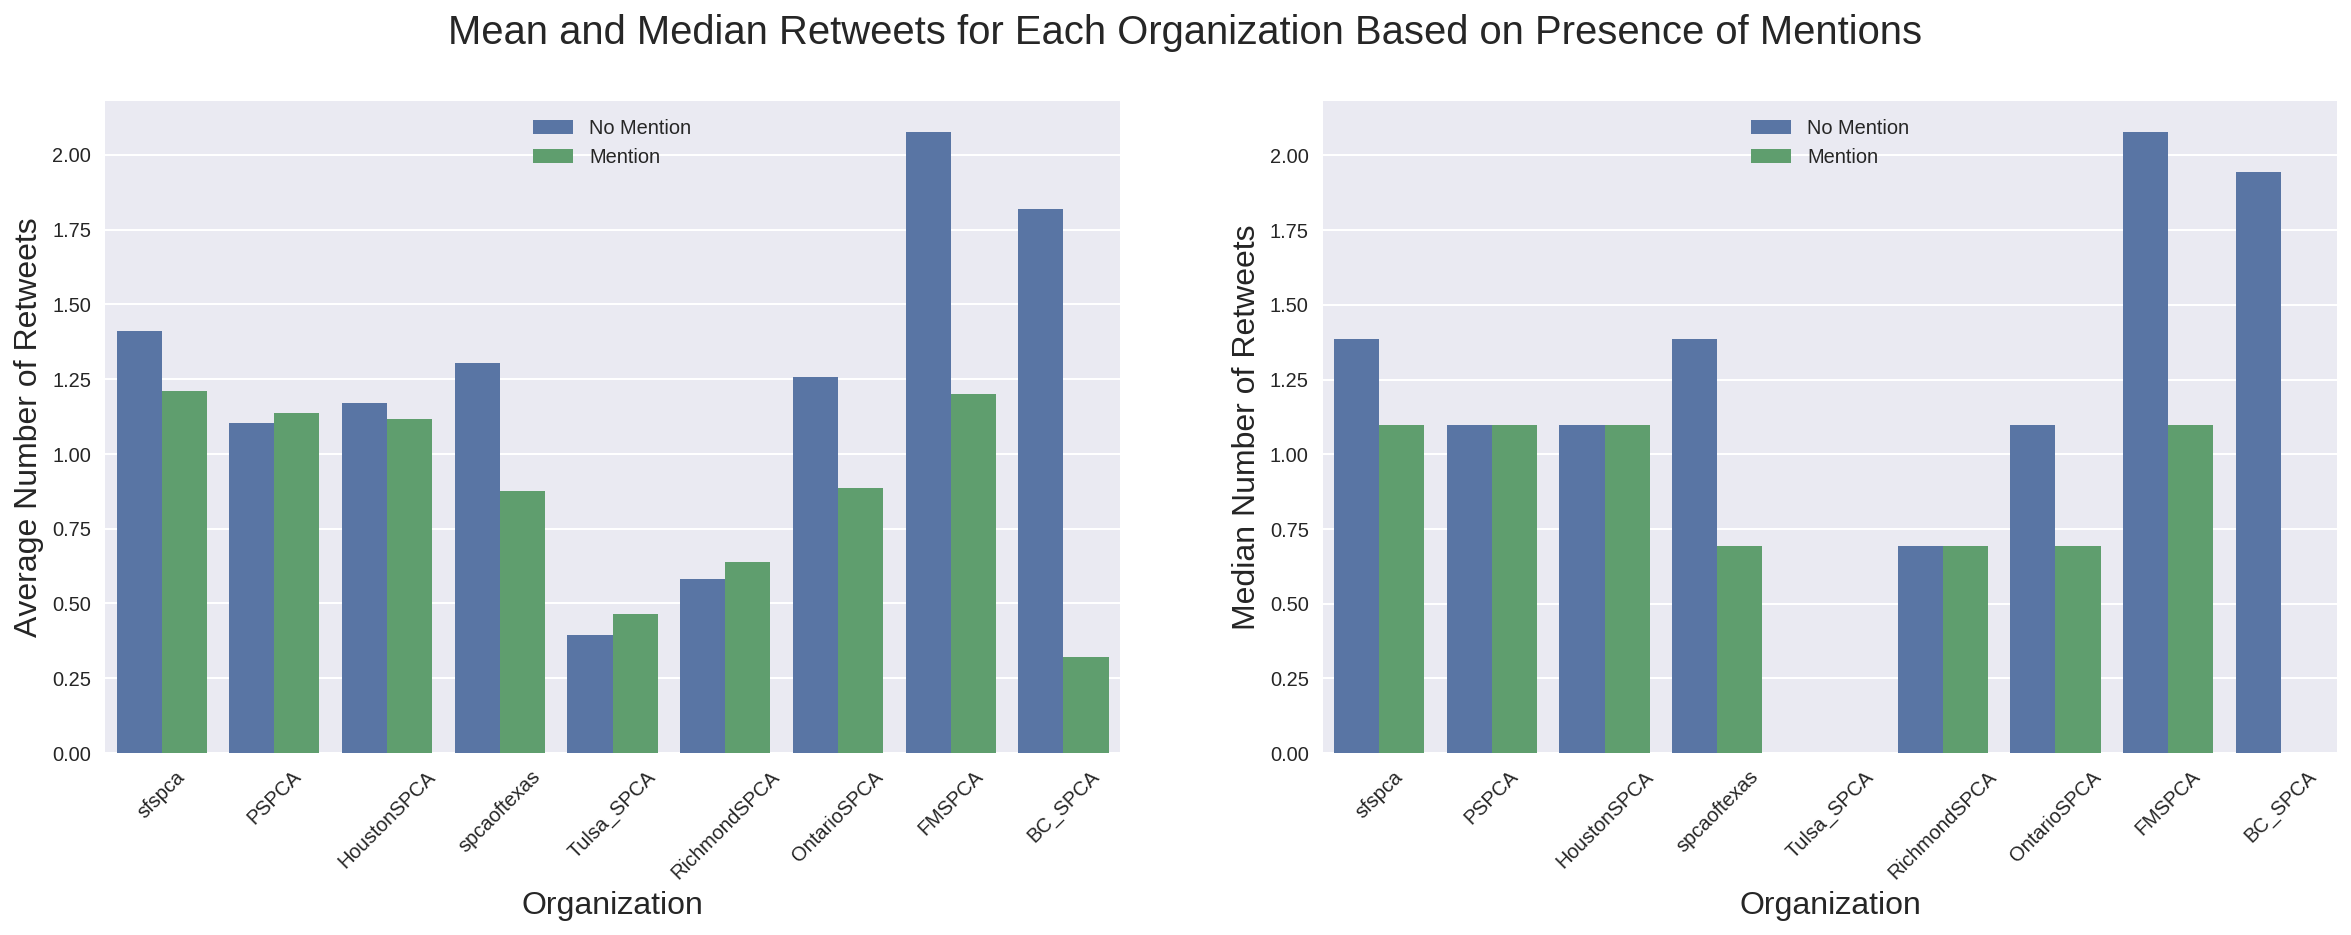

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
plt.suptitle('Mean and Median Retweets for Each Organization Based on Presence of Mentions', fontsize=20)
sns.barplot(x='username', y='retweets', hue='has_mention', data=df, ci=None, ax=axes[0])
sns.barplot(x='username', y='retweets', hue='has_mention', data=df, estimator=np.median,ci=None, ax=axes[1])
axes[0].set_ylabel('Average Number of Retweets')
axes[1].set_ylabel('Median Number of Retweets')
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    ax.legend(labels=['No Mention', 'Mention'], loc='upper center')
    ax.set_xlabel("Organization")
    ax.yaxis.label.set_fontsize(16)
    ax.xaxis.label.set_fontsize(16)

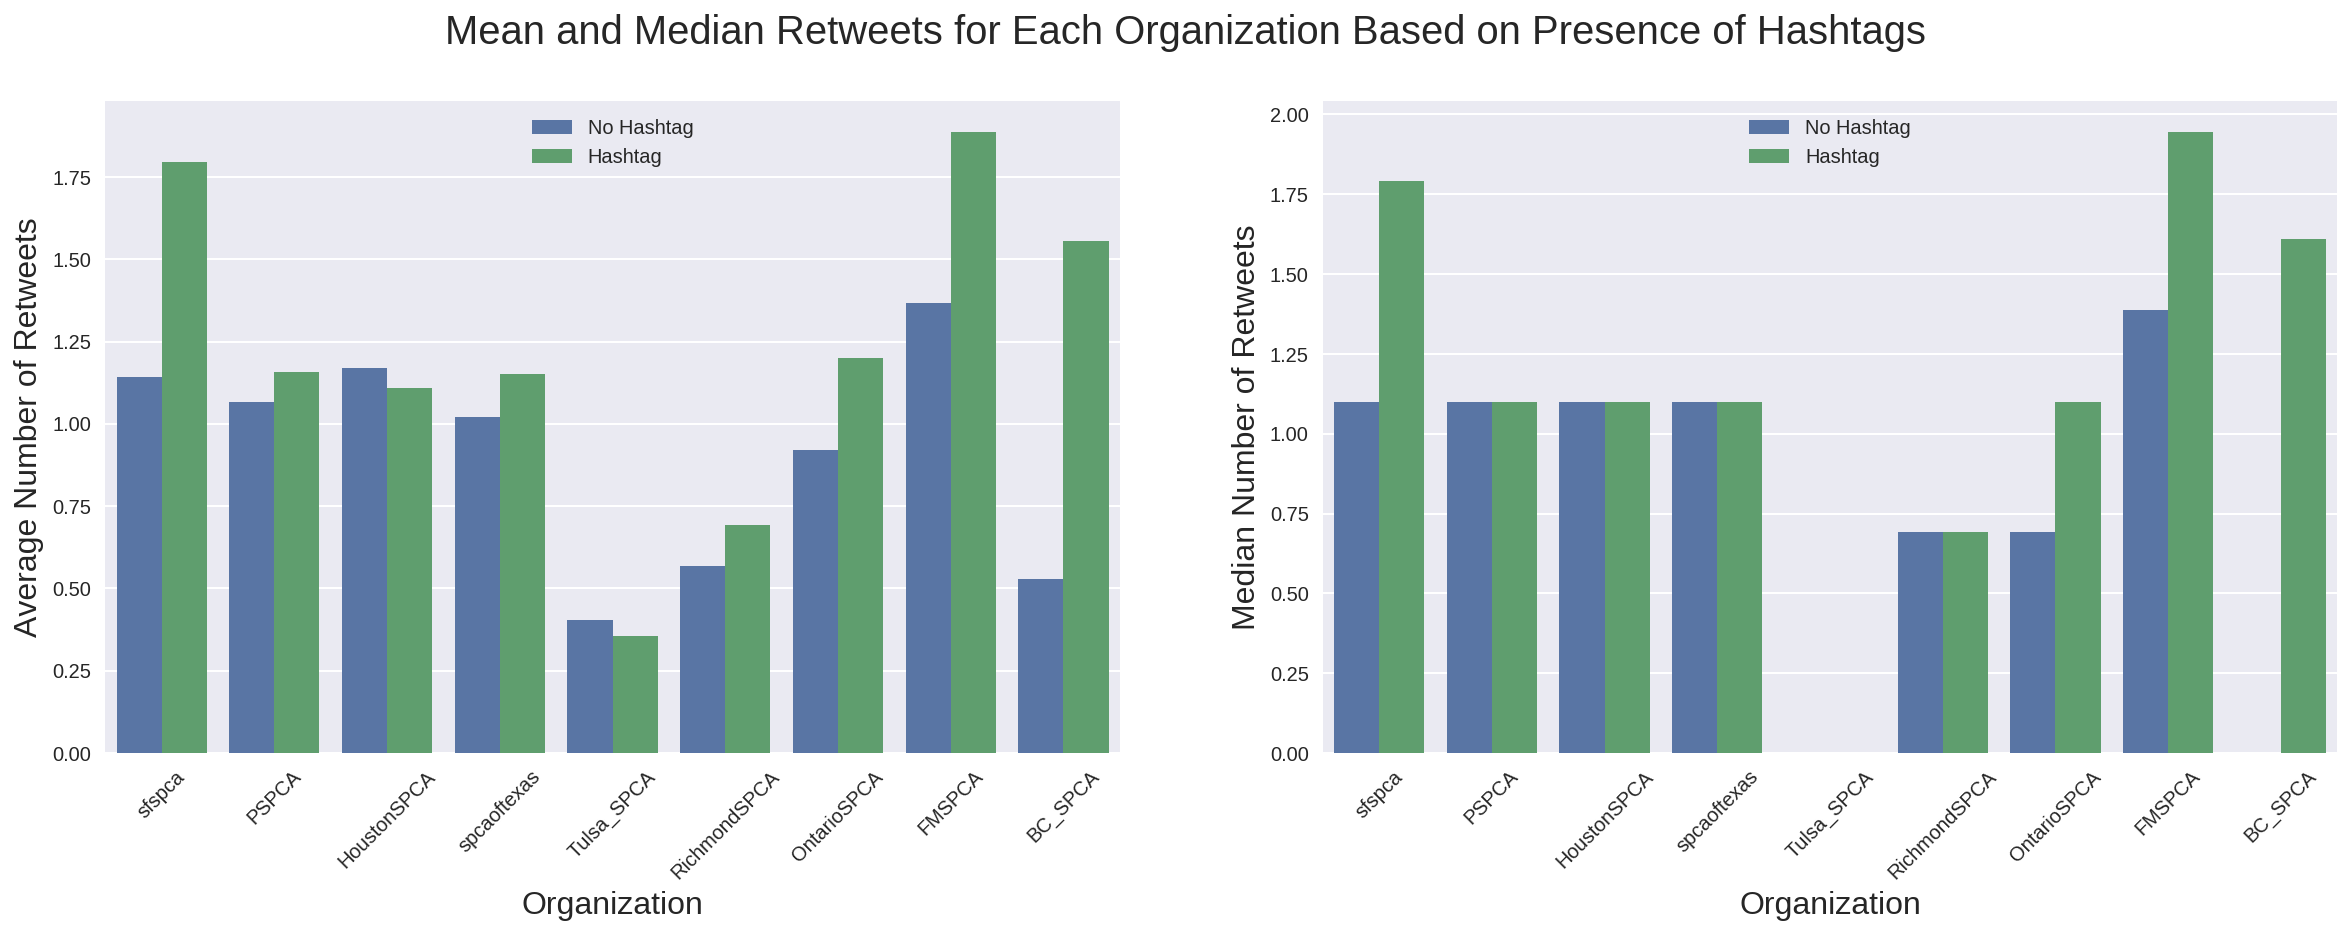

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
plt.suptitle('Mean and Median Retweets for Each Organization Based on Presence of Hashtags', fontsize=20)
sns.barplot(x='username', y='retweets', hue='has_hashtag', data=df, ci=None, ax=axes[0])
sns.barplot(x='username', y='retweets', hue='has_hashtag', data=df, estimator=np.median,ci=None, ax=axes[1])
axes[0].set_ylabel('Average Number of Retweets')
axes[1].set_ylabel('Median Number of Retweets')
for ax in axes:
    plt.sca(ax)
    ax.legend(labels=['No Hashtag', 'Hashtag'], loc='upper center')
    plt.xticks(rotation=45)
    ax.set_xlabel("Organization")
    ax.yaxis.label.set_fontsize(16)
    ax.xaxis.label.set_fontsize(16)

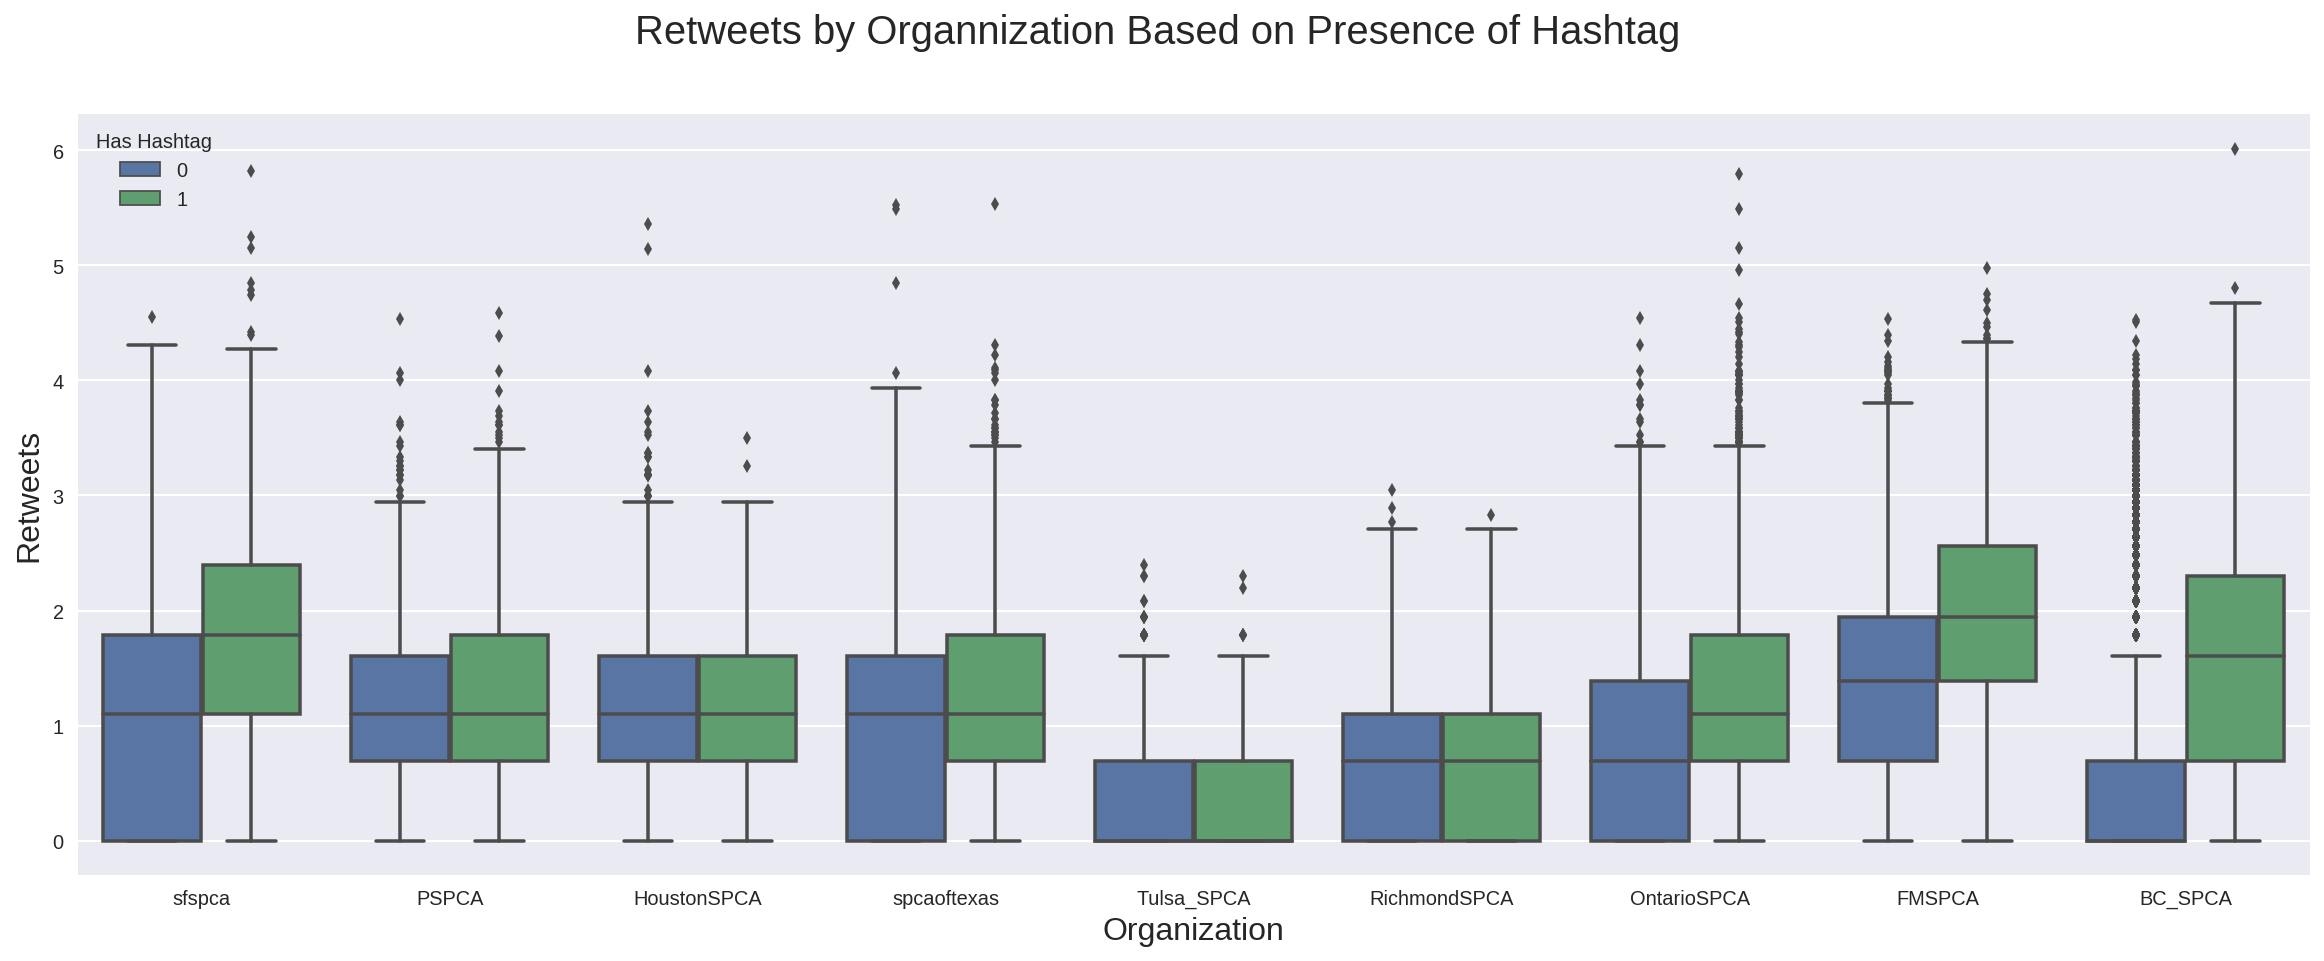

In [23]:
fig = plt.figure(figsize=(20,7))
plt.suptitle('Retweets by Organnization Based on Presence of Hashtag', fontsize=20)
sns.boxplot(x='username', y='retweets', hue='has_hashtag',data=df)
plt.xlabel('Organization', fontsize=16)
plt.ylabel('Retweets', fontsize=16)
# plt.legend(labels=['No Hashtag', 'Hashtag'])
plt.legend(title="Has Hashtag")
plt.show()

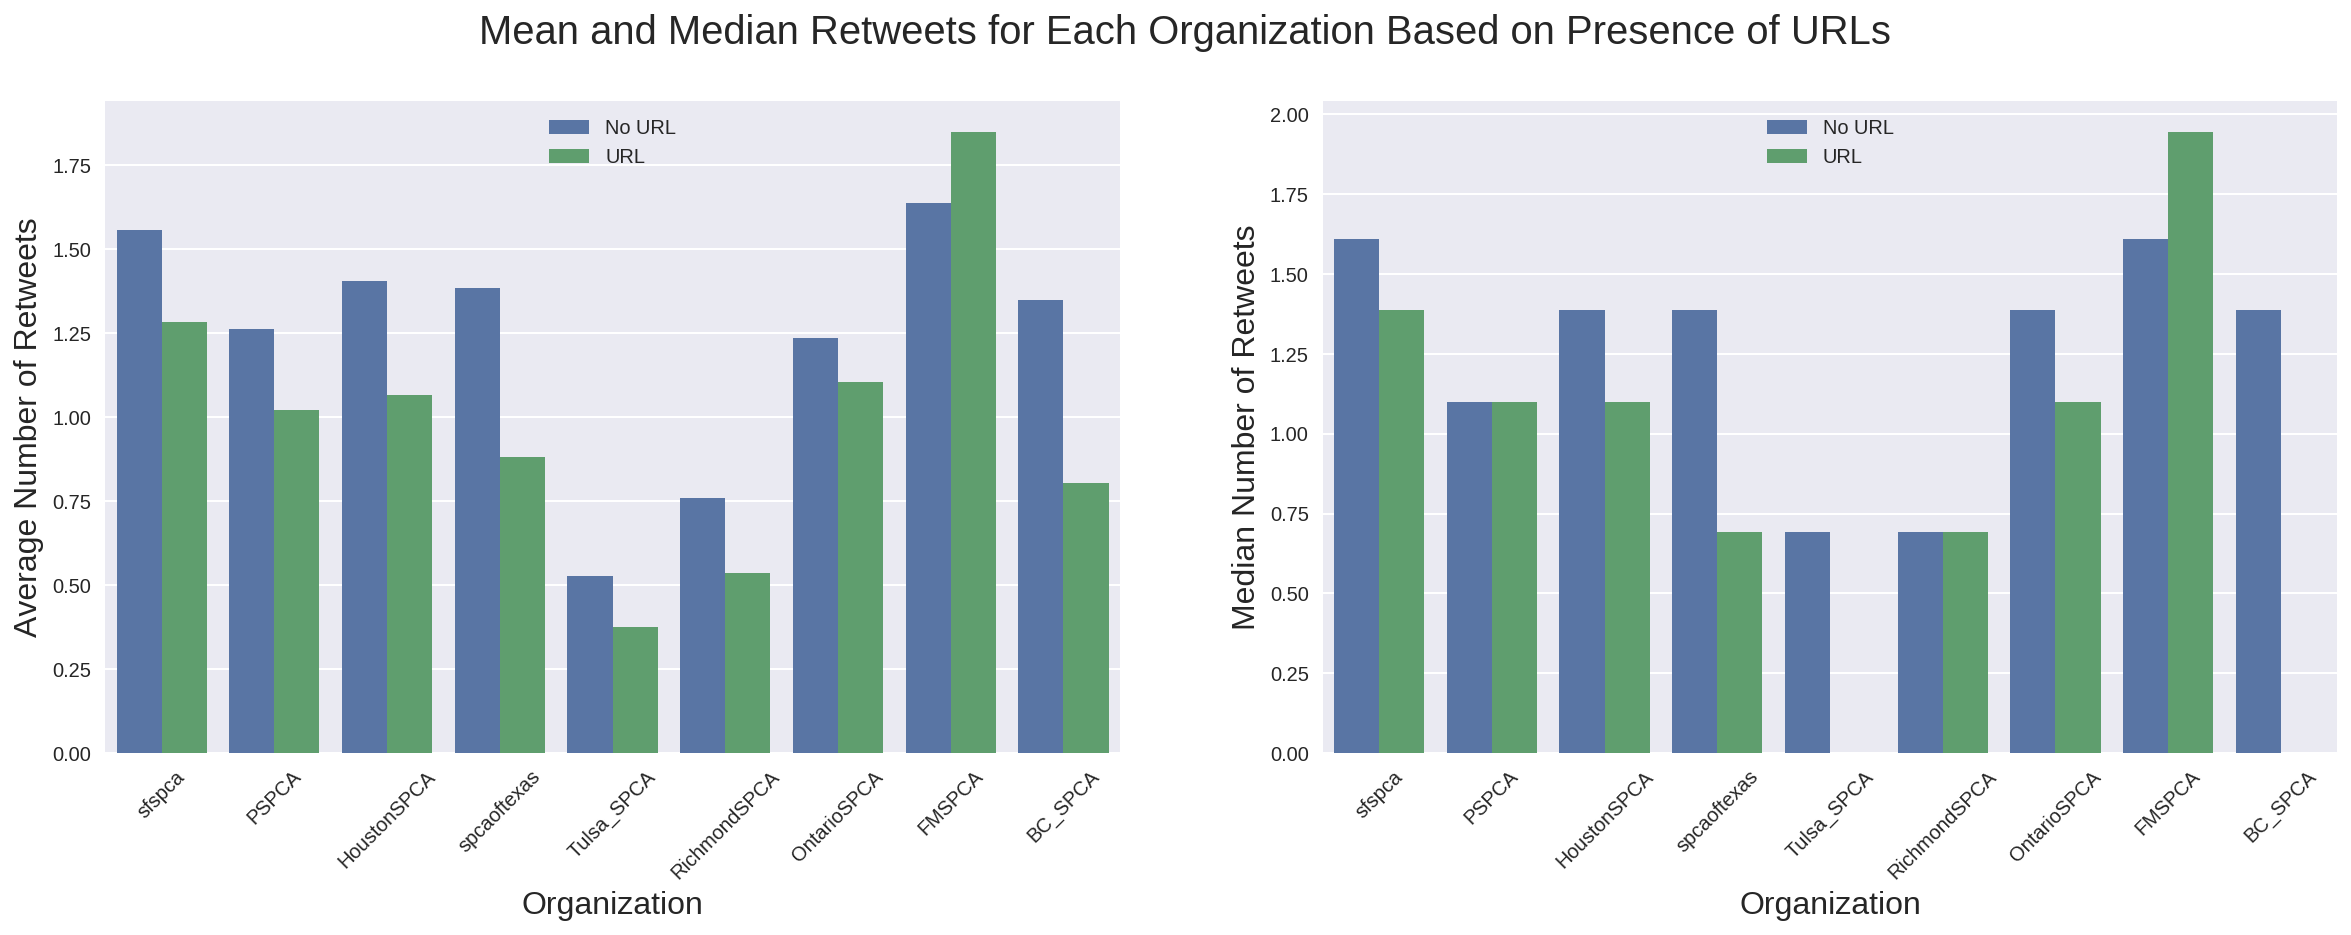

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
plt.suptitle('Mean and Median Retweets for Each Organization Based on Presence of URLs', fontsize=20)
sns.barplot(x='username', y='retweets', hue='has_url', data=df, ci=None, ax=axes[0])
sns.barplot(x='username', y='retweets', hue='has_url', data=df, estimator=np.median,ci=None, ax=axes[1])
axes[0].set_ylabel('Average Number of Retweets')
axes[1].set_ylabel('Median Number of Retweets')
for ax in axes:
    plt.sca(ax)
    ax.legend(labels=['No URL', 'URL'], loc='upper center')
    plt.xticks(rotation=45)
    ax.set_xlabel("Organization")
    ax.yaxis.label.set_fontsize(16)
    ax.xaxis.label.set_fontsize(16)

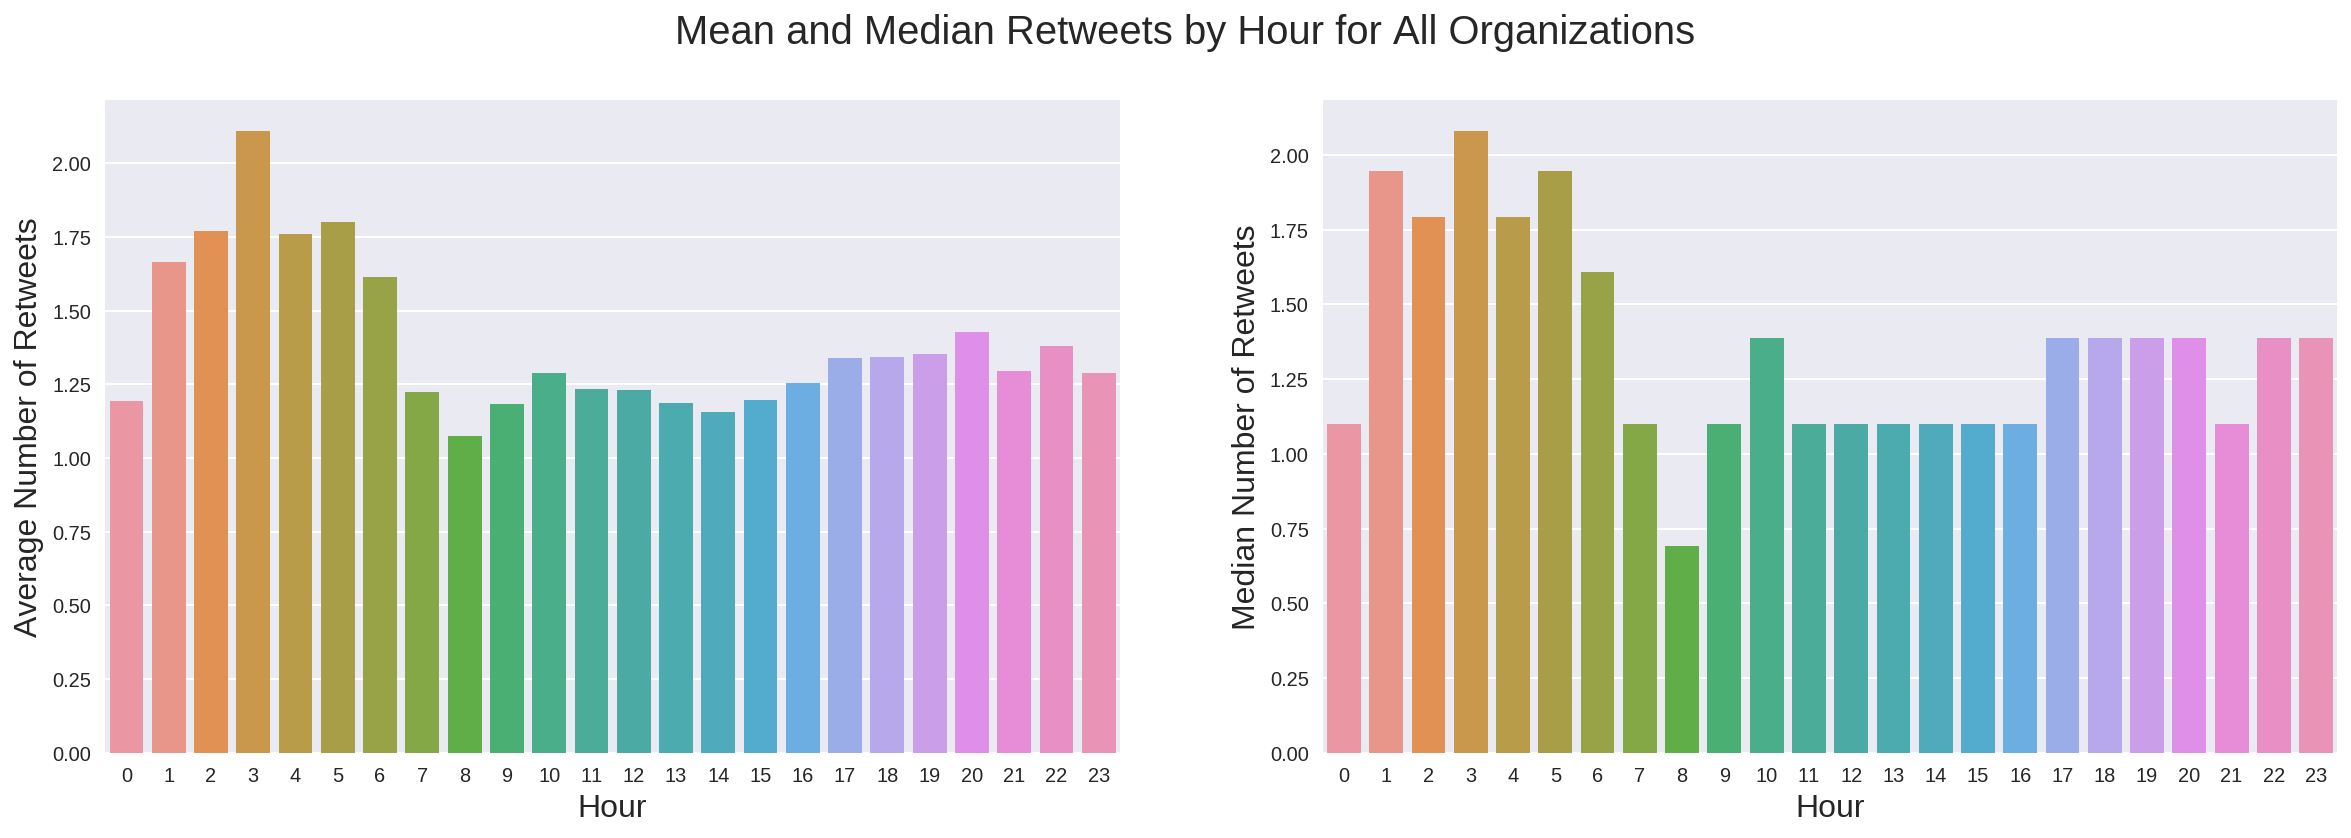

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
plt.suptitle('Mean and Median Retweets by Hour for All Organizations', fontsize=20)
sns.barplot(x='hour', y='retweets', data=df, ci=None, ax=axes[0])
sns.barplot(x='hour', y='retweets', data=df, estimator=np.median,ci=None, ax=axes[1])
axes[0].set_ylabel('Average Number of Retweets')
axes[1].set_ylabel('Median Number of Retweets')
for ax in axes:
    plt.sca(ax)
    ax.set_xlabel("Hour")
    ax.yaxis.label.set_fontsize(16)
    ax.xaxis.label.set_fontsize(16)

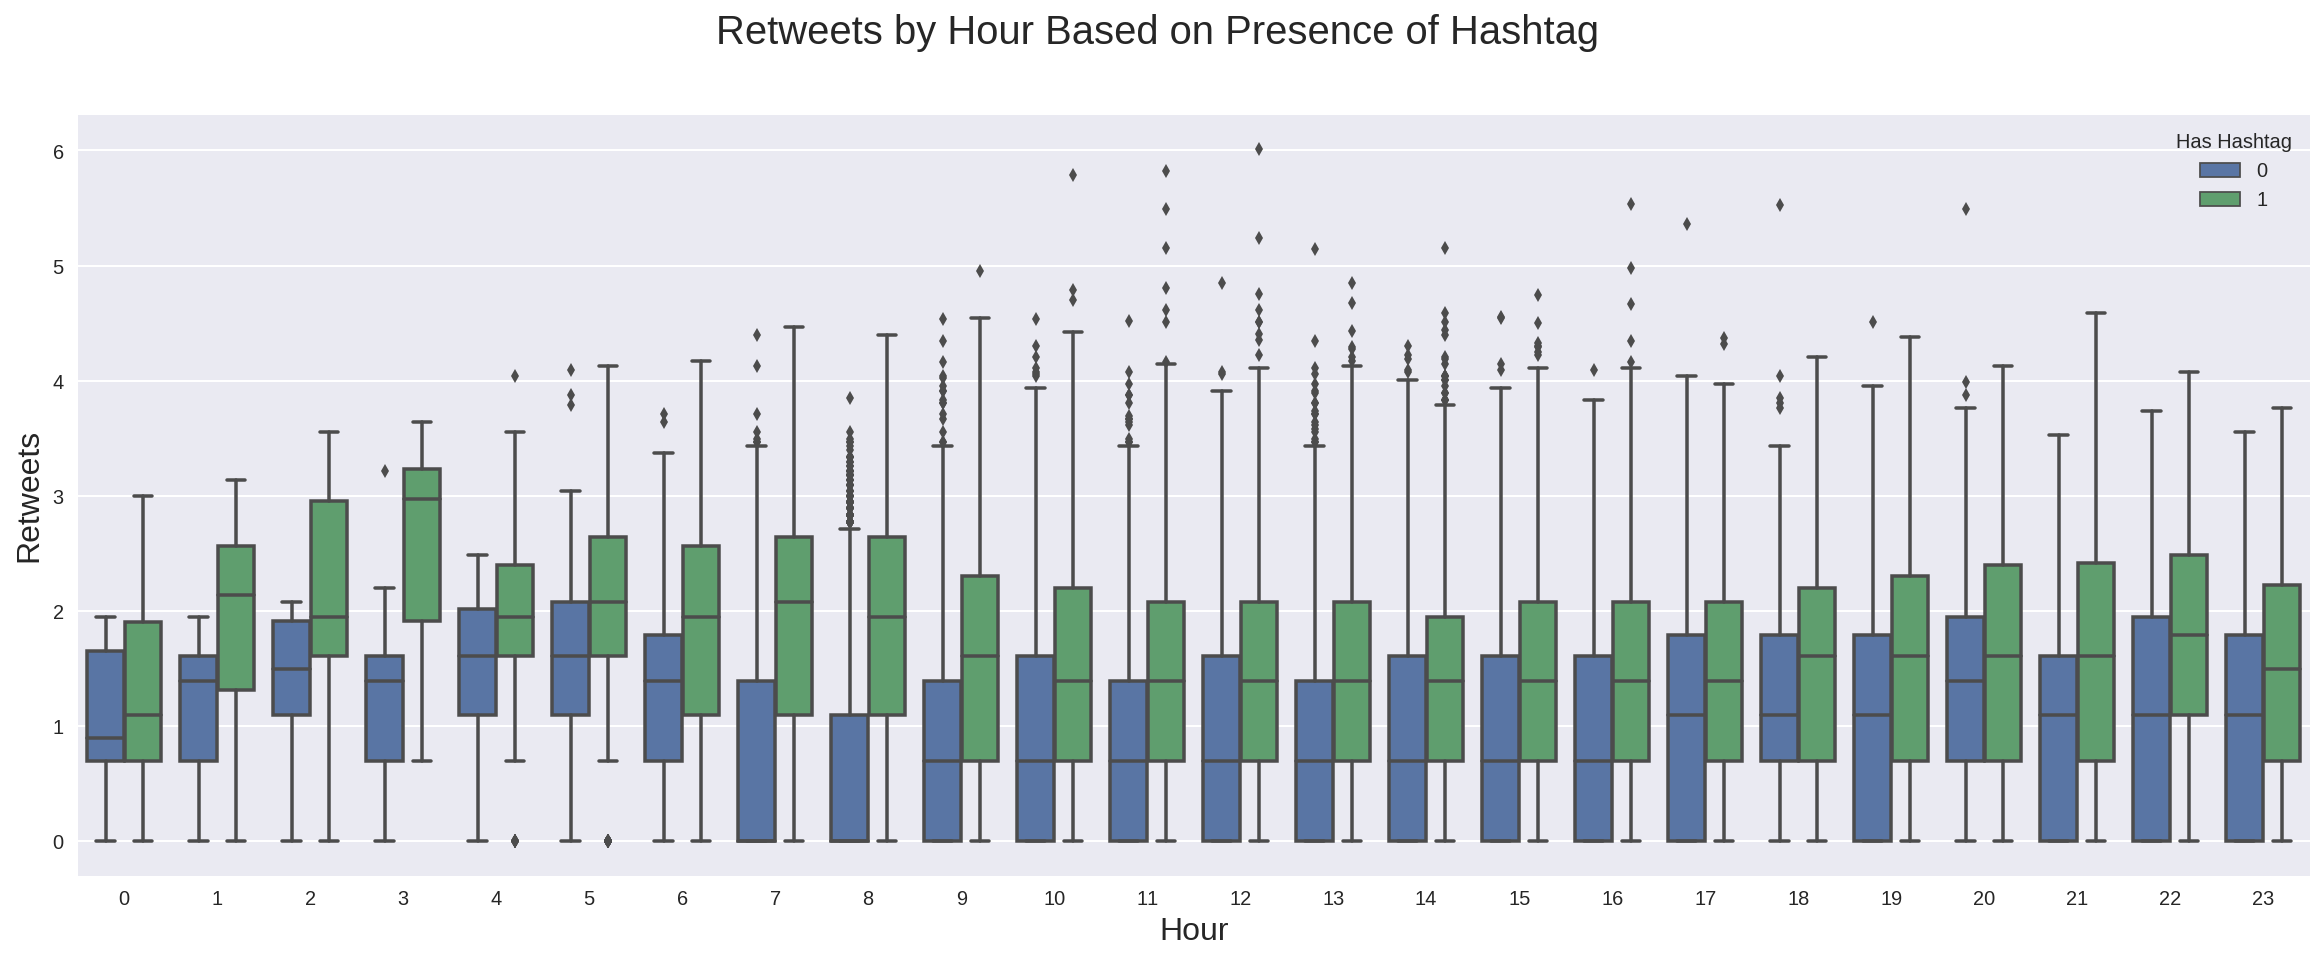

In [26]:
fig = plt.figure(figsize=(20,7))
plt.suptitle('Retweets by Hour Based on Presence of Hashtag', fontsize=20)
sns.boxplot(x='hour', y='retweets', hue='has_hashtag',data=df)
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Retweets', fontsize=16)
plt.legend(title='Has Hashtag')
plt.show()

In [27]:
# look at tweets at 3 am to see what's causing such a high value
df.loc[df.hour == 3].username.value_counts()

FMSPCA        43
sfspca         1
Tulsa_SPCA     1
Name: username, dtype: int64

**Note:**  
Almost all of the 3 am tweets are from the Alberta organization. Maybe they are using a scheduling tool like zoho or hootsuite.

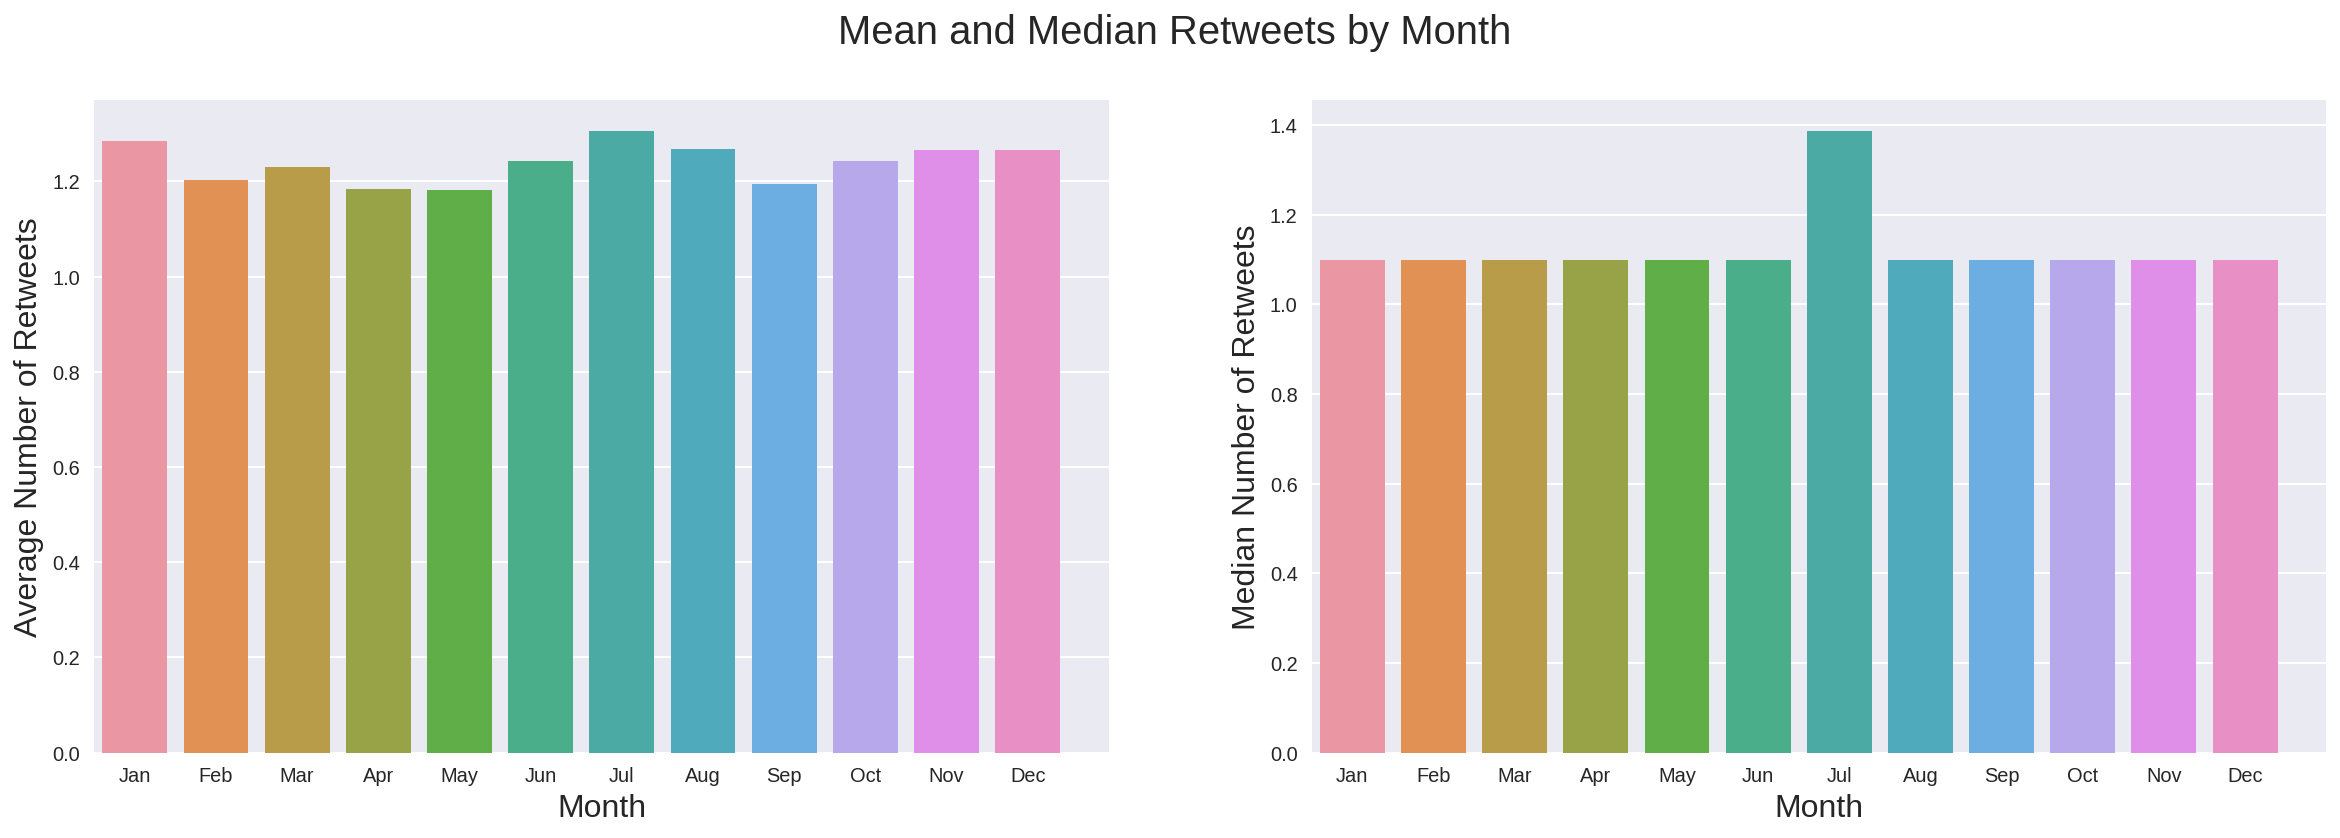

In [28]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
plt.suptitle('Mean and Median Retweets by Month', fontsize=20)
sns.barplot(x='month', y='retweets', data=df, ci=None, ax=axes[0])
sns.barplot(x='month', y='retweets', data=df, estimator=np.median, ci=None, ax=axes[1])
axes[0].set_ylabel('Average Number of Retweets')
axes[1].set_ylabel('Median Number of Retweets')
for ax in axes:
    plt.sca(ax)
    ax.set_xlabel("Month")
    plt.xticks(list(range(13)), months)
    ax.yaxis.label.set_fontsize(16)
    ax.xaxis.label.set_fontsize(16)

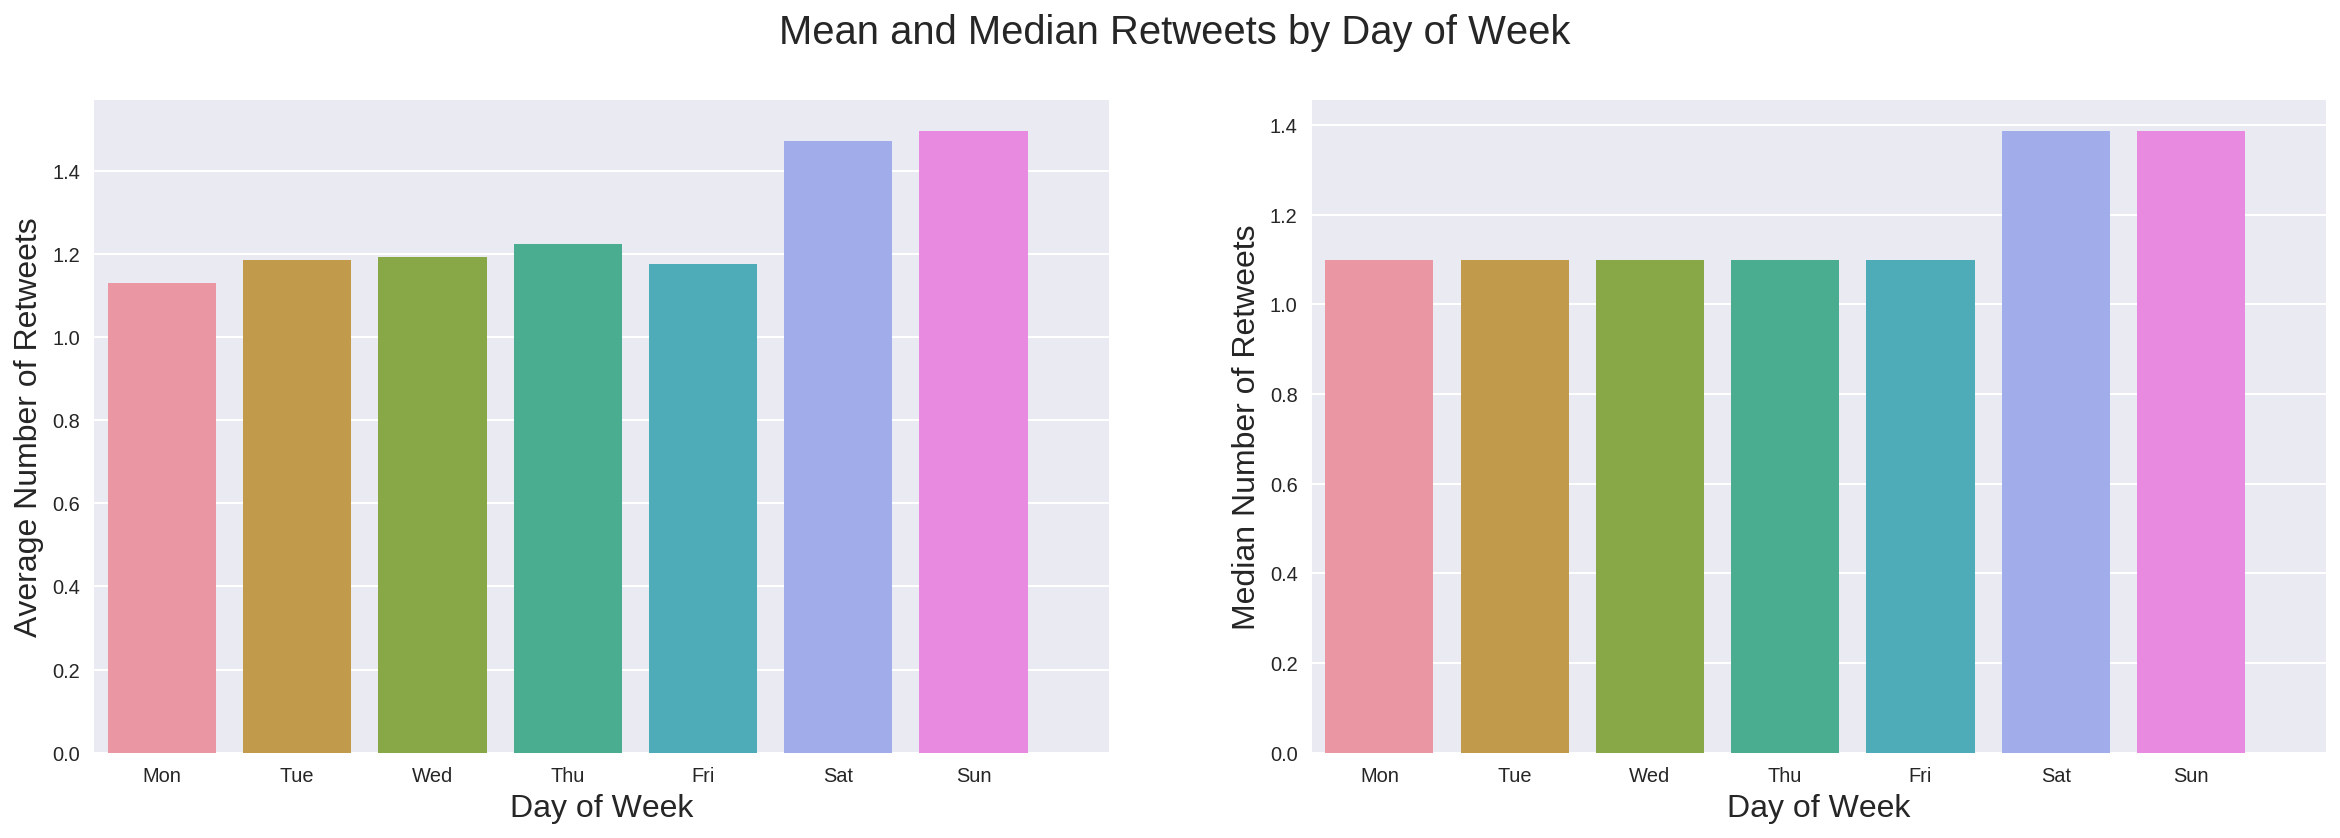

In [29]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
plt.suptitle('Mean and Median Retweets by Day of Week', fontsize=20)
sns.barplot(x='weekday', y='retweets', data=df, ci=None, ax=axes[0])
sns.barplot(x='weekday', y='retweets', data=df, estimator=np.median,ci=None, ax=axes[1])
axes[0].set_ylabel('Average Number of Retweets')
axes[1].set_ylabel('Median Number of Retweets')
for ax in axes:
    plt.sca(ax)
    ax.set_xlabel("Day of Week")
    plt.xticks(list(range(8)), days)
    ax.yaxis.label.set_fontsize(16)
    ax.xaxis.label.set_fontsize(16)

### Visualization Summary  
1. Having a mention seems to result in lower retweets.
1. Having a hashtag seems to result in higher retweets, even more so for some organizations (i.e. BC SPCA) and the increase varies a lot by time of day too.
1. Having a url has varying affects depending on organization.
1. It appears tweets sent in the very early morning hours have the highest number of retweets.
1. Tweets sent in July got a little bump in retweets, and it's interesting to note that none of the outliers were tweeted in July. Maybe I missed another natural disaster?
1. It looks like weekend tweets get more retweets than those sent during the week.

## Next Steps
1. Can I get number of followers from the Twitter API?  
**Result:** Yes, but only back to mid-2016  

1. Look into timezone of timestamp so that "hour" is local to user and day of week is local too. Might need to add this as tweets are pulled since adjustment for each SPCA may be different. Also got lots of tweets at 3 am from Alberta organization. Can this be real?  
**Result:** Fixed time zone issue and the graph remained relatively unchanged. I suspect Alberta is using a scheduling tool to send tweets in the wee hours. Maybe other organizations should do the same.

1. Investigate how those 11 tweets from non-SPCA users got into the data.  
**Result:** I've decided it's not worth investigating... just gonna drop them.  

1. Drop the tweets from Houston since Hurricane Harvey.  
**Result:** Dropped all the tweets during the time periods of three major natural disasters.


In [30]:
df.to_pickle('../data/3-post_eda.p')